## Notebook for Impact of Debiasing Word Embeddings on \\ Information Retrieval

This notebook is for making all the figures in the paper/poster. The only thing you need to download is the pretrained google news vectors, which can be found here:


https://code.google.com/archive/p/word2vec/

The following packages need to be installed:
- gensim
- sklearn
- matplotlib
- numpy
- umap

In [2]:
import gensim

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# I used this version: http://academictorrents.com/details/2aa0d0c6aff92f08719e409db04ecee4721cf21f
# Note: loading the embeddings takes around 10 minutes, and I recommend you to have at least 8 GB of ram. 
filepath = 'GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

# Using Memory Mapped files leads to significantly better performance, so save and reload:
# model.save('GN-vectors.bin')

# Load the wordvectors using memory mapped files:

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_file = datapath('glove.6B.300d.txt')
#tmp_file = get_tmpfile("test_word2vec.txt")

#_ = glove2word2vec(glove_file, tmp_file)
#model = KeyedVectors.load_word2vec_format(tmp_file)

# model = gensim.models.KeyedVectors.load('GN-vectors.bin', mmap='r')

In [3]:
# Using Memory Mapped files leads to significantly better performance, so save and reload:
#model.save('GN-vectors.bin')

# Load the wordvectors using memory mapped files:
#model = gensim.models.KeyedVectors.load('GN-vectors.bin', mmap='r')

First: The analogy convergences: 

To experiment with these convergences: The first word is the word where the bias starts, the second word is the 'negative' term, the third word is the positive term. So analogy_convergence('computer_programmer', 'he', 'she') starts by computing 'computer_programmer  -  he  +  she  =  homemaker'. 

This repeats until the analogy converges or more than N (default is 10) steps are taken.

In [4]:
def analogy_convergence(biassed_word, fromword = 'he', toword = 'she', N = 10):

    firstfrom = fromword
    firstto = toword
    biassed_from = biassed_word
    biassed_to = ""
    for i in range(N):
        analogy = model.most_similar(positive = [biassed_from, toword], negative = [fromword], topn = 1)[0][0]
        #analogy = most_similar(biassed_from, toword, fromword, n = 1)[0][0]
        print(biassed_from, " - ", fromword, " + ", toword, " = ", analogy)
        if analogy == biassed_to or analogy == biassed_from:
            break
        else:
            biassed_to = biassed_from
            biassed_from = analogy
            if i%2 == 0:
                fromword = firstto
                toword = firstfrom
            else:
                fromword = firstfrom
                toword = firstto
    if i == N:
        print("Convergence not reached within ", N, " steps")

In [5]:
analogy_convergence('carpenter', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


carpenter  -  he  +  she  =  seamstress
seamstress  -  she  +  he  =  carpenter


In [6]:
analogy_convergence('programmer', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


programmer  -  he  +  she  =  programmers
programmers  -  she  +  he  =  Martin_Thorborg_together
Martin_Thorborg_together  -  he  +  she  =  Henrik_Sørensen
Henrik_Sørensen  -  she  +  he  =  Martin_Thorborg_together


In [7]:
analogy_convergence('computer_programmer', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


computer_programmer  -  he  +  she  =  homemaker
homemaker  -  she  +  he  =  carpenter
carpenter  -  he  +  she  =  seamstress
seamstress  -  she  +  he  =  carpenter


In [8]:
analogy_convergence('doctor', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


doctor  -  he  +  she  =  nurse
nurse  -  she  +  he  =  doctor


In [9]:
analogy_convergence('pizzas', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


pizzas  -  he  +  she  =  cupcakes
cupcakes  -  she  +  he  =  waffles
waffles  -  he  +  she  =  cupcakes


Next the code for makin the PCA of word vectors:

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

def words_pca(word_list, transform = 'pca'):
    # Looking up the vectors per word
    bias_vectors = [model[word] for word in word_list]
    # scaling the wordvectors
    bias_vectors = StandardScaler().fit_transform(bias_vectors)
    # applying PCA with 2 components
    if transform == 'pca':
        pca = PCA(n_components=2)
        bias_pca = pca.fit_transform(bias_vectors)
    elif transform == 'tsne':
        bias_pca = TSNE(n_components=2).fit_transform(bias_vectors)
    else:
        bias_pca = umap.UMAP().fit_transform(bias_vectors)
    return bias_pca
    

In [11]:
# setting the plotsize
plt.rcParams['figure.figsize'] = [15, 7.5]
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

In [12]:
# In case you want to add a new list of words
def check_in_word2vec(wordlist):
    checked_list = []
    for word in wordlist:
        if word in model.vocab:
            checked_list.append(word)
    return checked_list

In [13]:
super_gendered = ['king', 'queen', 'brother', 'sister', 'mother', 'father',
                  'she', 'woman', 'he', 'man', 'grandpa', 'grandma', 'boy', 'girl',
                 'her', 'his', 'daughter', 'son', 'Mary', 'John']
super_gendered = check_in_word2vec(super_gendered)

C:\Users\emmag\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


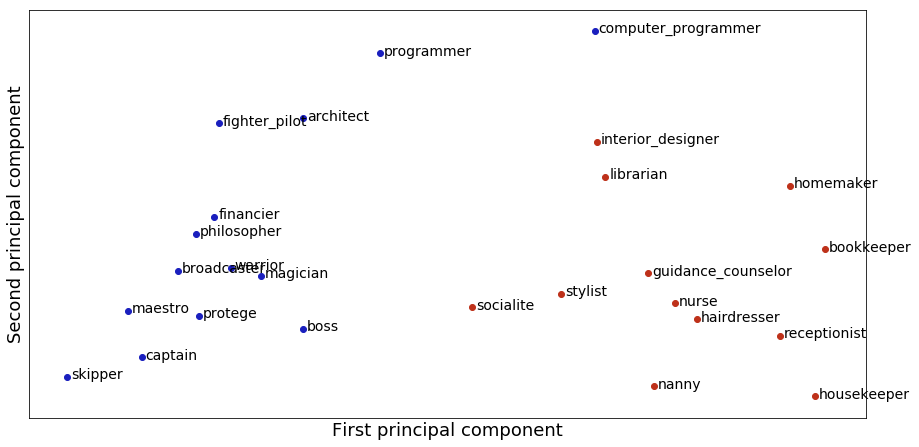

In [14]:
# list of biased words, without the genderwords:
male_bias =  ['maestro', 'skipper', 'protege', 'philosopher', 'captain', 'architect','financier', 'warrior', 'broadcaster','magician', 'fighter_pilot', 'boss', 'computer_programmer', 'programmer']
female_bias = ['homemaker', 'nurse', 'receptionist', 'librarian', 'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist','housekeeper', 'interior_designer', 'guidance_counselor']
bias_words = male_bias + female_bias

# Optional: add gendered words:
#bias_words = bias_words + super_gendered

# Calculating the bias
# Options for dimensionality reduction: pca, tsne and umap
bias_pca = words_pca(bias_words, transform = 'pca')


# Plotting the PCA with words
f = plt.figure()

some_words = ['homemaker', 'nurse', 'receptionist', 'librarian']
for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    if word in female_bias:
        plt.scatter(x, y, marker='o', color='#BE311A')
        plt.text(x+0.1, y-0.1, word, fontsize=14)
    elif word in male_bias:
        plt.scatter(x, y, marker='o', color='#1A1fBE')
        plt.text(x+0.1, y-0.1, word, fontsize=14)
    elif word in super_gendered:
        plt.scatter(x, y, marker='o', color='green')
        plt.text(x+0.1, y-0.1, word, fontsize=14)
    else:
        plt.scatter(x, y, marker='o', color='black')
        plt.text(x+0.1, y-0.1, word, fontsize=14)
        
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.xticks([])
plt.yticks([])


plt.show()

Next the code for the histogram and the PCA plot without the professions:

In [15]:
from scipy import spatial
import numpy as np
def word_projection(word, mode = 'inner'):
    if mode == 'inner':
        return round(np.inner(model['she']-model['he'], model[word]),2)
    elif mode == 'cosine':
        return round(spatial.distance.cosine(model['he'], model[word]) - spatial.distance.cosine(model['she'], model[word]),2)

In [16]:
bias_words = ["accountant", "acquaintance", "actor", "actress","adjunct_professor", "administrator", "adventurer", "advocate","aide","alderman", "alter_ego", "ambassador", "analyst", "anthropologist", "archaeologist", "archbishop", "architect", "artist","artiste", "assassin", "assistant_professor", "associate_dean", "associate_professor", "astronaut", "astronomer", "athlete", "athletic_director", "attorney", "author", "baker","ballerina", "ballplayer", "banker", "barber", "baron", "barrister", "bartender", "biologist", "bishop", "bodyguard", "bookkeeper","boss", "boxer", "broadcaster","broker", "bureaucrat", "businessman", "businesswoman", "butcher", "butler", "cab_driver", "cabbie", "cameraman", "campaigner", "captain", "cardiologist", "caretaker","carpenter", "cartoonist", "cellist","chancellor", "chaplain", "character", "chef", "chemist", "choreographer", "cinematographer", "citizen", "civil_servant", "cleric", "clerk","coach", "collector", "colonel", "columnist", "comedian", "comic", "commander", "commentator", "commissioner", "composer", "conductor", "confesses", "congressman", "constable", "consultant", "cop", "correspondent", "councilman", "councilor", "counselor","critic", "crooner", "crusader", "curator","custodian", "dad", "dancer", "dean", "dentist", "deputy", "dermatologist","detective", "diplomat", "director", "disc_jockey", "doctor", "doctoral_student", "drug_addict", "drummer", "economics_professor", "economist", "editor", "educator","electrician", "employee", "entertainer", "entrepreneur", "environmentalist","envoy", "epidemiologist", "evangelist", "farmer", "fashion_designer", "fighter_pilot", "filmmaker", "financier", "firebrand", "firefighter", "fireman", "fisherman", "footballer", "foreman", "freelance_writer", "gangster", "gardener","geologist", "goalkeeper", "graphic_designer", "guidance_counselor", "guitarist", "hairdresser", "handyman", "headmaster", "historian", "hitman", "homemaker", "hooker", "housekeeper", "housewife","illustrator", "industrialist", "infielder", "inspector", "instructor","interior_designer", "inventor", "investigator", "investment_banker", "janitor", "jeweler", "journalist","judge", "jurist", "laborer", "landlord", "lawmaker", "lawyer", "lecturer", "legislator", "librarian", "lieutenant", "lifeguard", "lyricist","maestro", "magician", "magistrate", "maid", "major_leaguer", "manager", "marksman", "marshal", "mathematician", "mechanic", "mediator","medic", "midfielder", "minister", "missionary", "mobster", "monk", "musician", "nanny", "narrator", "naturalist","negotiator", "neurologist", "neurosurgeon", "novelist", "nun", "nurse", "observer","officer", "organist", "painter", "paralegal", "parishioner", "parliamentarian", "pastor", "pathologist", "patrolman", "pediatrician","performer","pharmacist", "philanthropist", "philosopher", "photographer","photojournalist", "physician", "physicist", "pianist","planner","plastic_surgeon", "playwright", "plumber", "poet","policeman", "politician", "pollster", "preacher", "president", "priest", "principal", "prisoner", "professor", "professor_emeritus", "programmer", "promoter", "proprietor", "prosecutor","protagonist", "protege", "protester","provost", "psychiatrist","psychologist", "publicist", "pundit", "rabbi", "radiologist","ranger", "realtor", "receptionist", "registered_nurse", "researcher", "restaurateur", "sailor", "saint", "salesman", "saxophonist", "scholar", "scientist", "screenwriter", "sculptor", "secretary", "senator", "sergeant", "servant", "serviceman", "sheriff_deputy", "shopkeeper", "singer","singer_songwriter","skipper", "socialite", "sociologist","soft_spoken", "soldier", "solicitor", "solicitor_general", "soloist", "sportsman", "sportswriter", "statesman", "steward","stockbroker", "strategist", "student", "stylist", "substitute", "superintendent", "surgeon", "surveyor", "swimmer", "taxi_driver", "teacher","technician", "teenager","therapist", "trader", "treasurer","trooper", "trucker", "trumpeter", "tutor","tycoon", "undersecretary","understudy", "valedictorian", "vice_chancellor", "violinist", "vocalist","waiter", "waitress", "warden", "warrior", "welder", "worker", "wrestler", "writer"]

very_bias_words = []
male_bias = []
female_bias = []
female_or_male = []

female_cosine = []
male_cosine = []
gender_neutral = []

for word in bias_words:
    tresh = 0.0
    if abs(word_projection(word, mode = 'cosine')) >= tresh:
        very_bias_words.append(word)
        if word_projection(word, mode = 'cosine') > tresh:
            female_bias.append(word)
            female_or_male.append(1)
            female_cosine.append(abs(word_projection(word, mode = 'cosine')))
        elif word_projection(word, mode = 'cosine') < tresh:
            male_bias.append(word)
            female_or_male.append(-1)
            male_cosine.append(abs(word_projection(word, mode = 'cosine')))
        else:
            female_or_male.append(0)
            gender_neutral.append(word)

            
sorted(list(zip(female_bias, female_cosine)), key = lambda x: x[1], reverse = True)


[('businesswoman', 0.32),
 ('actress', 0.31),
 ('housewife', 0.3),
 ('homemaker', 0.27),
 ('registered_nurse', 0.27),
 ('nurse', 0.25),
 ('receptionist', 0.24),
 ('waitress', 0.24),
 ('librarian', 0.23),
 ('socialite', 0.23),
 ('ballerina', 0.22),
 ('hairdresser', 0.22),
 ('nanny', 0.22),
 ('paralegal', 0.22),
 ('maid', 0.21),
 ('nun', 0.21),
 ('bookkeeper', 0.2),
 ('stylist', 0.19),
 ('housekeeper', 0.18),
 ('interior_designer', 0.17),
 ('fashion_designer', 0.16),
 ('guidance_counselor', 0.16),
 ('dancer', 0.15),
 ('clerk', 0.14),
 ('educator', 0.13),
 ('pediatrician', 0.13),
 ('singer', 0.13),
 ('swimmer', 0.13),
 ('therapist', 0.13),
 ('counselor', 0.12),
 ('dermatologist', 0.12),
 ('graphic_designer', 0.12),
 ('publicist', 0.12),
 ('student', 0.12),
 ('teacher', 0.12),
 ('valedictorian', 0.11),
 ('vocalist', 0.11),
 ('singer_songwriter', 0.1),
 ('worker', 0.1),
 ('assistant_professor', 0.09),
 ('choreographer', 0.09),
 ('doctoral_student', 0.09),
 ('pharmacist', 0.09),
 ('soloist',

C:\Users\emmag\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


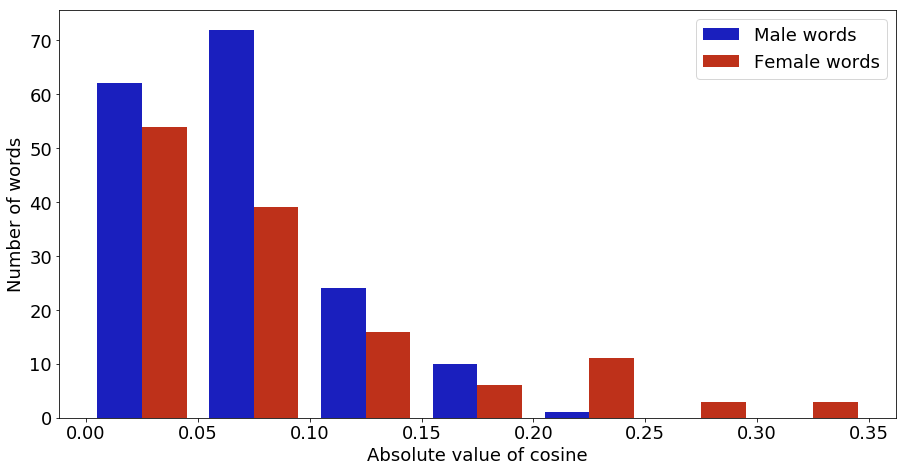

In [17]:
#bias_word_projection = [abs(word_projection(word, mode = 'cosine')) for word in very_bias_words]

bins = np.linspace(0, 0.35, 8)
x = male_cosine
y = female_cosine

f = plt.figure()
plt.hist([x, y], bins, label=['Male words', 'Female words'], color = ['#1A1fBE', '#BE311A'])
plt.legend(loc='upper right')
plt.xlabel('Absolute value of cosine')
plt.ylabel('Number of words')
plt.show()

C:\Users\emmag\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


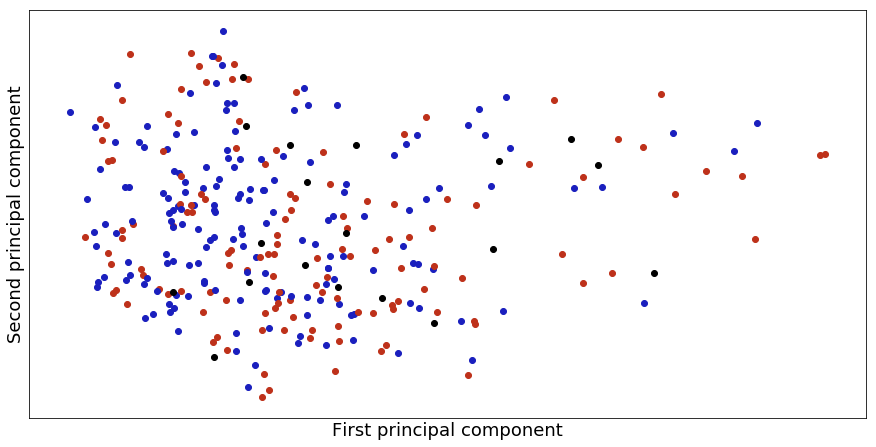

In [18]:
# Calculating the bias
# Options for dimensionality reduction: pca, tsne and umap
bias_pca = words_pca(bias_words, transform = 'pca')


# Plotting the PCA with words
f = plt.figure()

some_words = ['homemaker', 'nurse', 'receptionist', 'librarian']
for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    if word in female_bias:
        plt.scatter(x, y, marker='o', color='#BE311A')
    elif word in male_bias:
        plt.scatter(x, y, marker='o', color='#1A1fBE')
    elif word in super_gendered:
        plt.scatter(x, y, marker='o', color='green')
    else:
        plt.scatter(x, y, marker='o', color='black')
        
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.xticks([])
plt.yticks([])


plt.show()